In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


In [2]:
# Cell 2: Read CSV (đổi path nếu cần)
df = pd.read_csv('Apple_clean.csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,7.611786,7.619643,7.520000,7.526071,6.326138,352410800
1,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.424604,493729600
2,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.435713,601904800
3,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.333343,552160000
4,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.321635,477131200


In [3]:
# Cell 3: Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()  # đảm bảo tăng dần theo thời gian
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,7.611786,7.619643,7.520000,7.526071,6.326138,352410800
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.424604,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.435713,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.333343,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.321635,477131200


In [4]:
# Cell 4: Select Close column as DataFrame (1 cột)
df_Close = df[['Close']].copy()
df_Close.head()


,Close
Date,
2009-12-31,7.526071
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714


In [5]:
# Cell 5: Min-max normalization
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(np.array(df_Close).reshape(-1,1))
# đảm bảo dạng numpy array 2D
data_scaled = np.array(data_scaled).reshape(-1,1)


In [6]:
# Cell 6: Split into train/validate/test (ratio 6:2:2)
train_size = int(0.6 * len(data_scaled))
val_size = int(0.2 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[:train_size].reshape(-1,1)
val_data = data_scaled[train_size: train_size + val_size].reshape(-1,1)
test_data = data_scaled[train_size + val_size : ].reshape(-1,1)

print("Sizes -> total:", len(data_scaled), "train:", len(train_data), "val:", len(val_data), "test:", len(test_data))


Sizes -> total: 3982 train: 2389 val: 796 test: 797


In [7]:
# Cell 7: Initialize best variables
best_alpha = None
best_mse = float('inf')
best_rmse = None
best_mape = None
best_msle = None
best_y_pred_val = None


In [8]:
# Cell 8: Training process - grid search alpha (0.1 .. 0.9)
for alpha in np.arange(0.1, 1.0, 0.1):
    alpha = round(alpha, 1)
    history = train_data.flatten().copy()  # 1D array của giá trị scaled
    y_pred_val = []

    for _ in range(len(val_data)):
        model = SimpleExpSmoothing(history, initialization_method='estimated')
        model_fit = model.fit(smoothing_level=alpha, optimized=False)
        pred = model_fit.forecast(1)  # 1-step forecast
        y_pred_val.append(pred[0])
        # cập nhật history bằng chính giá trị dự đoán (theo logic mẫu)
        history = np.append(history, pred[0])

    # convert lists/arrays về dạng để tính metrics (inverse transform)
    val_data_temp = scaler.inverse_transform(val_data.reshape(-1,1)).reshape(-1,1)
    y_pred_val_arr = scaler.inverse_transform(np.array(y_pred_val).reshape(-1,1)).reshape(-1,1)

    mape = mean_absolute_percentage_error(val_data_temp, y_pred_val_arr)
    mse = mean_squared_error(val_data_temp, y_pred_val_arr)
    rmse = np.sqrt(mse)
    # mean_squared_log_error yêu cầu không có giá trị âm; Close thường dương — nếu 0 có thể gây lỗi
    try:
        msle = mean_squared_log_error(val_data_temp, y_pred_val_arr)
    except ValueError:
        msle = np.nan

    if mse < best_mse:
        best_alpha = alpha
        best_mse = mse
        best_rmse = rmse
        best_mape = mape
        best_msle = msle
        best_y_pred_val = y_pred_val_arr.copy()

print("Best alpha: ", best_alpha)


Best alpha:  0.5


In [9]:
# Cell 9: Print validate metrics
print(f"MAPE on Validate dataset: ", best_mape)
print(f"RMSE on Validate dataset: ", best_rmse)
print(f"MSLE on Validate dataset: ", best_msle)
print(f"MSE (best) on Validate dataset: ", best_mse)


MAPE on Validate dataset:  0.5099649132809546
RMSE on Validate dataset:  77.80089289149822
MSLE on Validate dataset:  0.7530499684301637
MSE (best) on Validate dataset:  6052.97893471438


In [10]:
# Cell 10: Testing process using best_alpha
y_pred_test = []
# bắt đầu history từ train + (chúng ta có thể thêm validate thực tế hoặc dựa trên mẫu chỉ dùng history từ train+pred_val)
# Ở mẫu ban đầu thường bắt đầu history = train_data + val_data (rồi update khi dự đoán test). 
# Ở đây ta theo logic chuẩn: history = train_data + val_data (dùng giá trị thực của validate)
history = np.concatenate([train_data.flatten(), val_data.flatten()])

for _ in range(len(test_data)):
    model = SimpleExpSmoothing(history, initialization_method='estimated')
    model_fit = model.fit(smoothing_level=best_alpha, optimized=False)
    pred = model_fit.forecast(1)
    y_pred_test.append(pred[0])
    history = np.append(history, pred[0])


In [11]:
# Cell 11: Evaluate test accuracy (inverse transform)
test_data_orig = scaler.inverse_transform(test_data.reshape(-1,1)).reshape(-1,1)
y_pred_test_arr = scaler.inverse_transform(np.array(y_pred_test).reshape(-1,1)).reshape(-1,1)

test_mape = mean_absolute_percentage_error(test_data_orig, y_pred_test_arr)
test_mse = mean_squared_error(test_data_orig, y_pred_test_arr)
test_rmse = np.sqrt(test_mse)
try:
    test_msle = mean_squared_log_error(test_data_orig, y_pred_test_arr)
except ValueError:
    test_msle = np.nan

print("MAPE on Test dataset: ", test_mape)
print("RMSE on Test dataset: ", test_rmse)
print("MSLE on Test dataset: ", test_msle)
print("MSE on Test dataset: ", test_mse)


MAPE on Test dataset:  0.16162308023423938
RMSE on Test dataset:  41.26840243420115
MSLE on Test dataset:  0.04459592437071312
MSE on Test dataset:  1703.0810394711796


In [12]:
# Cell 12: Prepare forecast date index (next 30 days)
last_date = df.index[-1]
next_date = last_date + pd.DateOffset(days=1)
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()


In [13]:
# Cell 13: Predict the next 30 days (using full history up to end of data)
y_next_30_days = []
# history_full: train + val + test (scaled values)
history_full = data_scaled.flatten().copy()

for _ in range(30):
    model = SimpleExpSmoothing(history_full, initialization_method='estimated')
    model_fit = model.fit(smoothing_level=best_alpha, optimized=False)
    pred = model_fit.forecast(1)
    y_next_30_days.append(pred[0])
    history_full = np.append(history_full, pred[0])

# inverse transform to original scale for printing/plotting
y_next_30_days_orig = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1,1)).reshape(-1,1)
print("Predicted closing prices for the next 30 days:")
print(y_next_30_days_orig.flatten())


Predicted closing prices for the next 30 days:
[267.47987125 267.47987125 267.47987125 267.47987125 267.47987125
 267.47987125 267.47987125 267.47987125 267.47987125 267.47987125
 267.47987125 267.47987125 267.47987125 267.47987125 267.47987125
 267.47987125 267.47987125 267.47987125 267.47987125 267.47987125
 267.47987125 267.47987125 267.47987125 267.47987125 267.47987125
 267.47987125 267.47987125 267.47987125 267.47987125 267.47987125]


In [14]:
# Cell 14: Prepare series for plotting (inverse transformed)
train_plot = scaler.inverse_transform(train_data.reshape(-1,1)).reshape(-1)
val_plot = scaler.inverse_transform(val_data.reshape(-1,1)).reshape(-1)
pred_val_plot = best_y_pred_val.reshape(-1)  # already inverse transformed in Cell 8
test_plot = scaler.inverse_transform(test_data.reshape(-1,1)).reshape(-1)
pred_test_plot = y_pred_test_arr.reshape(-1)
next30_plot = y_next_30_days_orig.reshape(-1)


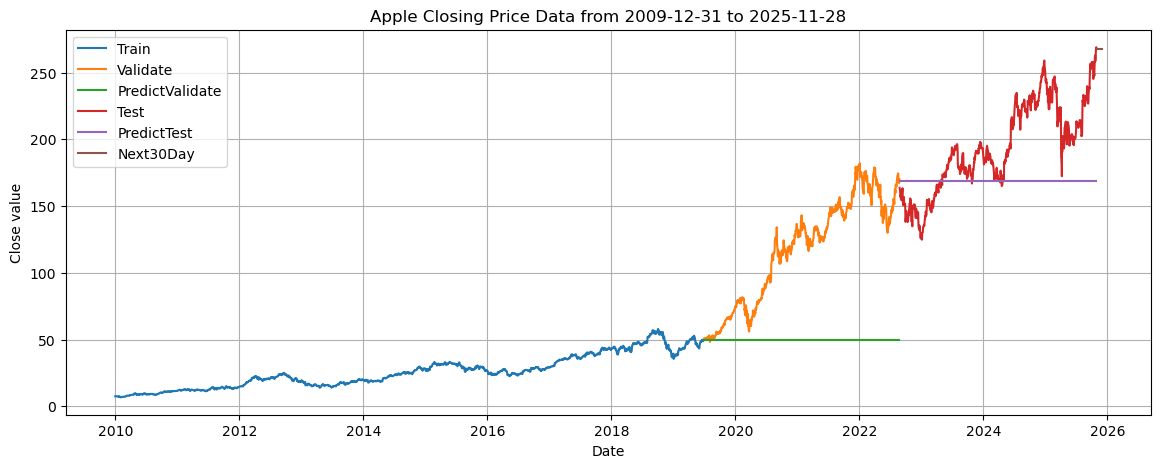

In [15]:
# Cell 15: Visualization (match sample)
plt.figure(figsize=(14,5))

# Train
plt.plot(df.index[:train_size], train_plot, label='Train')
# Validate (actual)
plt.plot(df.index[train_size: train_size + val_size], val_plot, label='Validate')
# Predict Validate
plt.plot(df.index[train_size: train_size + val_size], pred_val_plot, label='PredictValidate')
# Test actual
plt.plot(df.index[train_size + val_size : train_size + val_size + len(test_plot)], test_plot, label='Test')
# Predict Test
plt.plot(df.index[train_size + val_size : train_size + val_size + len(pred_test_plot)], pred_test_plot, label='PredictTest')
# Next 30 days
plt.plot(index_next_30_days, next30_plot, label='Next30Day')

plt.legend(['Train','Validate','PredictValidate','Test','PredictTest','Next30Day'])
plt.grid()
plt.title(f"Apple Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('ETS_622_Apple.png')
plt.show()
